<a href="https://colab.research.google.com/github/ujeongmin/ESAA/blob/main/ESAA_HW_4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(파이썬 머신러닝 완벽 가이드)
## [CH8 텍스트 분석]



### 06. 토픽 모델링(Topic Modeling) - 20 뉴스그룹
토픽 모델링 : 문서 집합에 숨어 있는 주제를 찾아내는 것, 숨겨진 주제를 효과적으로 표현할 수 있는 중심 단어를 함축적으로 추출
* 자주 사용되는 기법은 LSA(Latent Semantic Analysis)와 LDA(Latent Dirichlet Allocation, 차원 축소의 LDA와 다른 것임)
* LDA는 Count 기반의 벡터화만 사용함




In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 8개의 주제를 추출
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

# 위에서 cats 변수로 기재된 카테고리만 추출. fetch_20newsgroups()의 categories에 cats 입력
news_df = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=cats, random_state=0)

# LDA는 Count 기반의 벡터화만 적용
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))

feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


* LatentDirichletAllocation 클래스의 n_components 파라미터를 이용해 토픽 개수를 8개(뉴스그룹에서 추출했던)로 조정

In [11]:
lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

* fit을 수행하면 객체는 components_ 속성값을 가지게 됨
* 개별 토픽별로 각 word 피처가 얼마나 많이 그 토픽에 할당됐는지에 대한 수치
* 높은 값일수록 해당 word 피처는 그 토픽의 중심 word가 됨

In [12]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

* components_ 값만으로는 한눈에 보기가 어려우므로 display_topics() 함수를 만들어서 각 토픽별로 연관도가 높은 순으로 Word를 나열해보기

In [13]:
def display_topics(model, feature_names, no_top_words):
  for topic_index, topic in enumerate(model.components_):
    print('Topic #', topic_index)

    # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array 인덱스를 반환
    topic_word_indexes = topic.argsort()[::-1]
    top_indexes = topic_word_indexes[:no_top_words]

    # top_indexes 대상인 인덱스별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
    feature_concat = ' '.join([feature_names[i] for i in top_indexes])
    print(feature_concat)

# CountVectorizer 객체 내의 전체 word의 명칭을 get_features_names()를 통해 추출
feature_names = count_vect.get_feature_names_out()

# 토픽별 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


* 각 토픽별로 명확한 주제어들이 추출되었는지 확인해보기

### 08. 문서 유사도
#### 문서 유사도 측정 방법 - 코사인 유사도
벡터의 크기보다는 벡터의 상호 방향성, 즉 두 벡터 사이의 사잇각이 얼마나 유사한지 수치로 적용한 것

In [14]:
import numpy as np

def cos_similarity(v1,v2):
  dot_product = np.dot(v1,v2)
  l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
  similarity = dot_product / l2_norm

  return similarity

* 예시로 TF-IDF로 벡터화된 행렬로 유사도 비교해보기

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [16]:
# TFidfVectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환
feature_vect_dense = feature_vect_simple.todense()

# 첫번째 문장과 두번째 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

# 첫번째 문장과 두번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect2)
print('문장1, 문장2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장1, 문장2 Cosine 유사도: 0.402


In [18]:
# 첫번째 문장과 세번째 문장
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect1, vect3)
print('문장1, 문장3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

# 두번째 문장과 세번째 문장
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect2, vect3)
print('문장2, 문장3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장1, 문장3 Cosine 유사도: 0.404
문장2, 문장3 Cosine 유사도: 0.456


* 이번에는 사이킷런에서 제공하는 sklearn.metrics.pairwise.cosine_similarity() 함수를 사용
* 파라미터는 (비교 기준이 되는 문서의 피처 행렬, 비교되는 문서의 피처 행렬)
* 희소 행렬, 밀집 행렬 모두와 행렬, 배열 모두 가능하여 별도의 변환 작업 필요 없음

In [19]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


* 앞에 1이 거슬린다면 비교 대상에 [1:]을 넣어서 비교 기준 문서를 제외해주면 됨

In [20]:
similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


* 모든 개별 문서 쌍으로 코사인 유사도도 ndarray 형태로 가능 (첫번째 row는 1번 문서와 2,3번째 문서의 코사인 유사도)

In [21]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


#### Opinion Review 데이터 세트를 이용한 문서 유사도 측정


In [31]:
# 앞에서 정의한 함수 가져오기

from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [33]:
import pandas as pd
import glob, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from google.colab import drive
drive.mount('/content/gdrive')

path = r'/content/gdrive/MyDrive/ESAA/data/topics'
all_files = glob.glob(os.path.join(path, '*.data'))
filename_list = []
opinion_text = []

for file_ in all_files:
  df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
  filename_ = file_.split('\\')[-1]
  filename = filename_.split('.')[0]
  filename_list.append(filename)
  opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})


from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [35]:
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


* 군집들 중 호텔을 주제로 군집화된 문서를 이용해 다른 문서 간의 유사도를 알아보기

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 군집화된 데이터임. DataFrame에서 해당 인덱스를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 군집화된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ', comparison_docname, ' 와 타 문서 유사도#####')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력해 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서 간의 코사인 유사도 측정 '''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화된 문서들의 DataFrame Index: Index([ 0,  1,  2,  6,  7,  8,  9, 13, 14, 15, 17, 18, 24, 26, 27, 31, 37, 38,
       39, 41, 42, 43, 46, 49, 50],
      dtype='int64')
##### 비교 기준 문서명  /content/gdrive/MyDrive/ESAA/data/topics/display_garmin_nuvi_255W_gps  와 타 문서 유사도#####
[[1.         0.07214808 0.06723268 0.08211019 0.10383889 0.02631334
  0.19665144 0.07146012 0.0197642  0.02108241 0.15187003 0.02141378
  0.30598598 0.50278164 0.02792002 0.07586943 0.12333832 0.01796937
  0.0605971  0.02105941 0.20615269 0.10182582 0.06712755 0.01912972
  0.04622382]]


* 유사도 높은 순으로 이를 정렬하고 시각화

Text(0.5, 1.0, '/content/gdrive/MyDrive/ESAA/data/topics/display_garmin_nuvi_255W_gps')

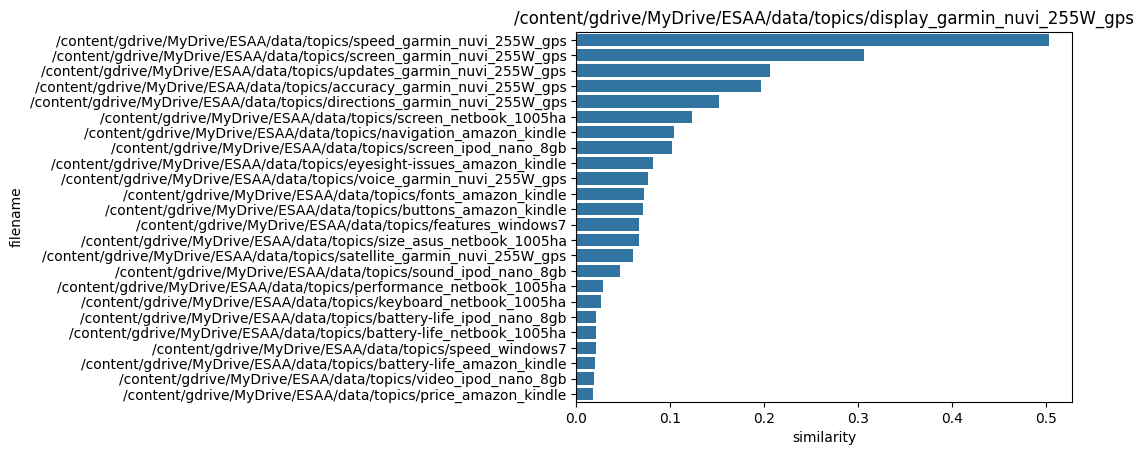

In [37]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)

### 09. 한글 텍스트 처리 - 네이버 영화 평점 감성 분석
대표적인 파이썬 기반의 한글 형태소 패키지인 KoNLPy

#### 한글 NLP 처리의 어려움
띄어쓰기와 다양한 조사 때문에 한글 언어 처리가 어려움

#### KoNLPy 소개
형태소 분석이란 말뭉치를 단어로서 의미를 가지는 최소 단위인 형태소 어근 단위로 쪼개고 각 형태소에 품사 태킹(POS tagging)을 부착하는 작업을 일반적으로 지칭

In [38]:
pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 27.2 MB/s eta 0:00:00


#### 데이터 로딩

In [43]:
import pandas as pd

train_df = pd.read_csv('/content/gdrive/MyDrive/ESAA/data/ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


* 1이 긍정, 0이 부정 감성

In [44]:
train_df['label'].value_counts()

label
0    75173
1    74827
Name: count, dtype: int64

* document 칼럼의 Null 값은 공백으로 변환
* 문자가 아닌 숫자의 경우 단어적인 의미로 부족하므로 파이썬의 정규 표현식 모듈인 re를 이용해 공백으로 변환

In [45]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d는 숫자를 의미함)
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r'\d+', ' ', x))

# 테스트 데이터 세트를 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('/content/gdrive/MyDrive/ESAA/data/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x : re.sub(r'\d+', ' ', x))

# id 칼럼 삭제 수행
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

* 한글 형태소 엔진은 SNS 분석에 적합한 Twitter 클래스를 이용
* Twitter 객체의 morphs() 메서드를 이용하면 문장을 형태소 단어 형태로 토큰화해 list 객체로 반환

In [46]:
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
  # 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
  tokens_ko = twitter.morphs(text)
  return tokens_ko

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs() 객체를 이용한 tokenizer를 사용, ngram_range는 (1,2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


* 로지스틱 회귀를 이용해 분류 기반의 감정 분석 수행, 그리드서치CV로 하이퍼 파라미터 C 최적화

In [49]:
# 로지스틱 회귀를 이용해 감정 분석 분류 수행
lg_clf = LogisticRegression(random_state=0)

# 파라미터 C 최적화를 위해 GridSearchCV를 이용
params = {'C': [1,3.5,4.5,5.5,10]}

grid_cv = GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'C': 3.5} 0.8593


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


* 테스트 세트를 이용해 예측할 때는 학습할 때 적용한 TfidfVectorizer를 그대로 사용해야 함

In [50]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환함
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ', accuracy_score(test_df['label'], preds))

Logistic Regression 정확도:  0.86186
